<a href="https://www.kaggle.com/datasets/rtatman/lego-database">Lego colours database</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from PIL import Image
from math import sqrt
from collections import Counter

In [2]:
# Convert colour hex values to 8bit RGB:
lego_colours = pd.read_csv('colors.csv', index_col='id')

In [3]:
lego_colours = lego_colours.drop([-1, 64, 9999], axis=0)

In [4]:
solid_lego_colours = lego_colours[lego_colours['is_trans'] == 'f']

In [5]:
solid_lego_colours = solid_lego_colours.rename(columns={'rgb': 'hex'})

In [6]:
# Remove the different versions of black
solid_lego_colours = solid_lego_colours[solid_lego_colours['hex'] != '000000']

In [7]:
rgb_values = []
for hex_val in solid_lego_colours['hex']:
    h = hex_val.lstrip('#')
    rgb_val = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
    rgb_values.append(rgb_val)

solid_lego_colours['RGB'] = rgb_values

In [8]:
image = Image.open('Mou-Aysha-portrait-photography-3.jpg')

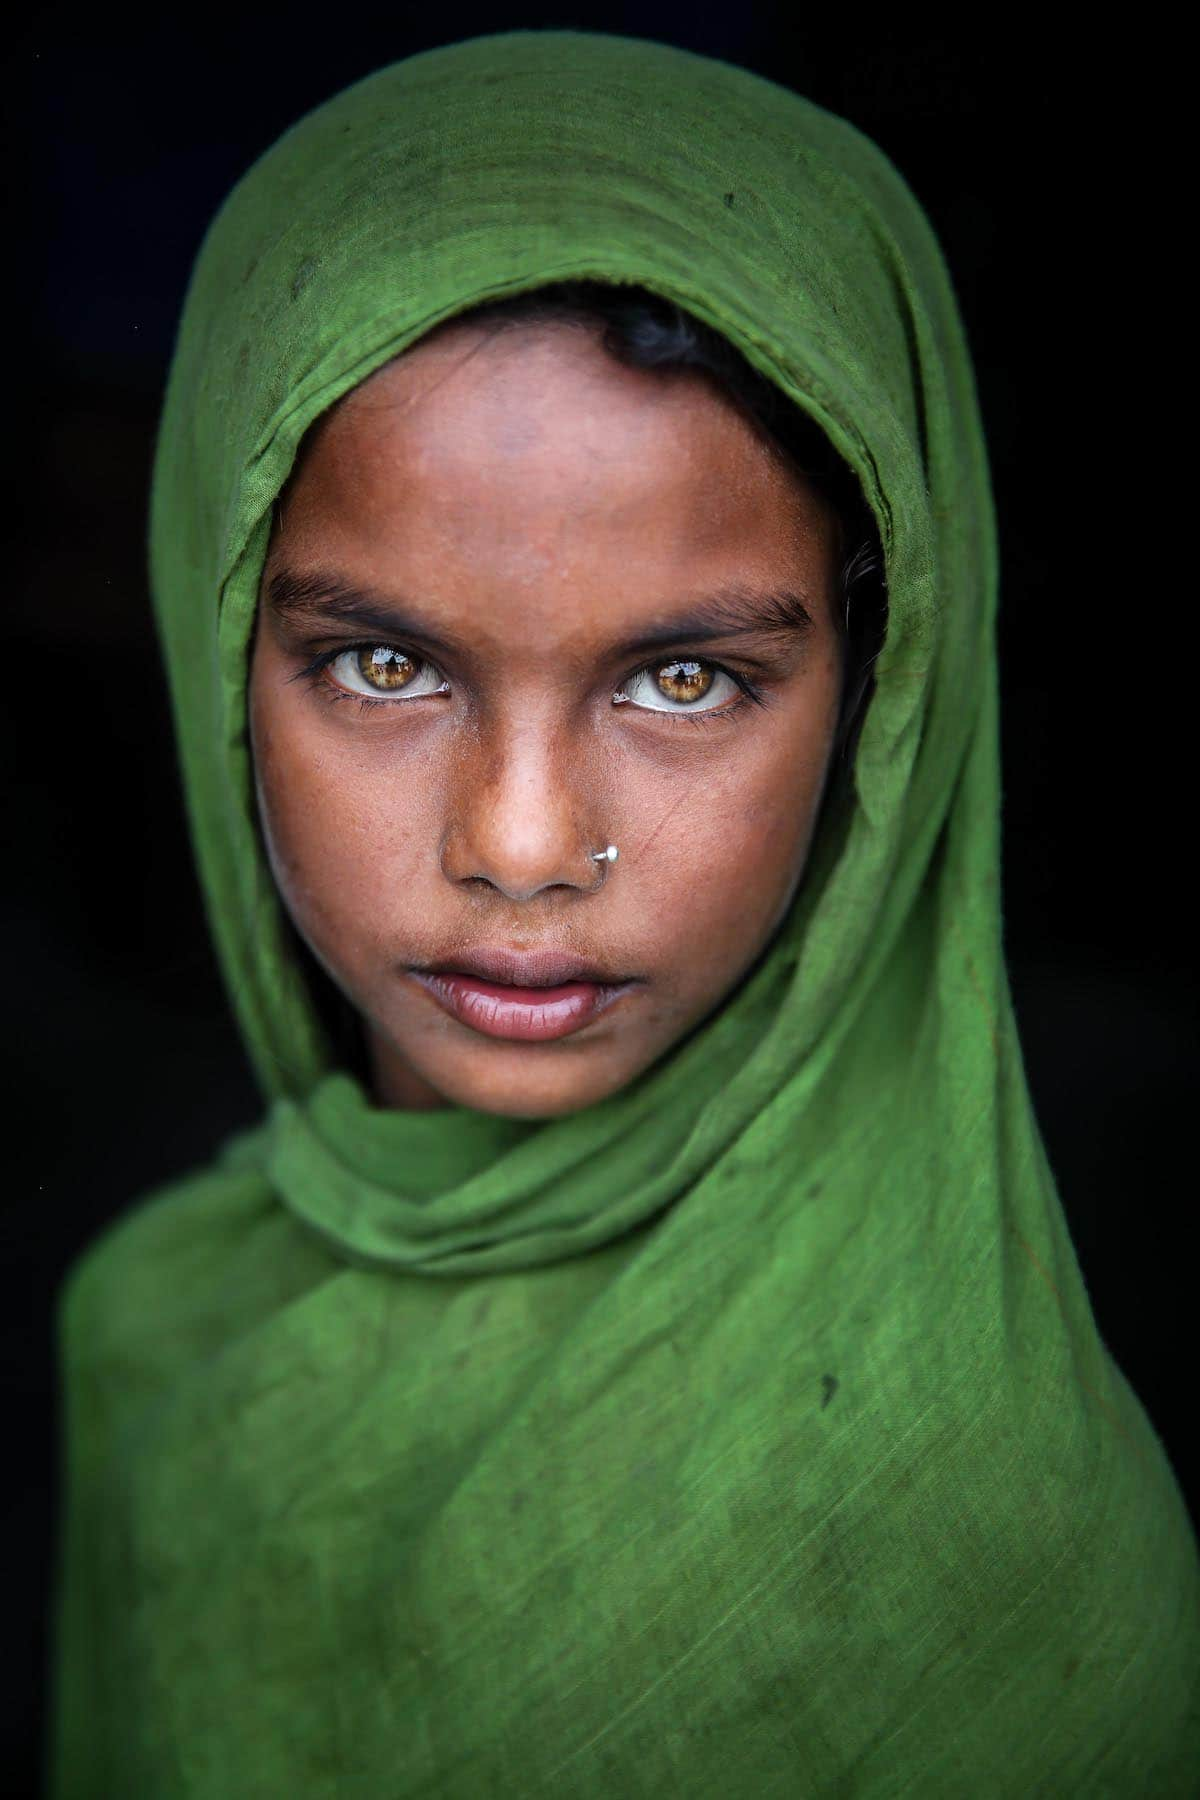

In [9]:
image

In [10]:
ratio = image.size[1]/image.size[0]
print(f'Your image is of size {image.size[1]} x {image.size[0]} px and has a ratio of: {ratio}')

Your image is of size 1800 x 1200 px and has a ratio of: 1.5


In [11]:
painting_base_size = int(input('Enter base size for the painting in mm. Value must be an integer: '))

Enter base size for the painting in mm. Value must be an integer: 300


In [12]:
painting_size = (painting_base_size, int(painting_base_size * ratio))
lego_painting_size = (int(painting_size[0]/7.8), int(painting_size[1]/7.8))
number_of_lego_pixels = lego_painting_size[0] * lego_painting_size[1]
actual_size = (round(lego_painting_size[0]*7.8, 2), round(lego_painting_size[1]*7.8, 2))
print(f'The actual size will be {actual_size[0]} x {actual_size[1]} mm.')
print(f'The painting will have {number_of_lego_pixels} pieces, arranged in {lego_painting_size[0]} x {lego_painting_size[1]} grid.')

The actual size will be 296.4 x 444.6 mm.
The painting will have 2166 pieces, arranged in 38 x 57 grid.


In [13]:
print('resizing...')

# Resize image
image = image.resize((lego_painting_size[0], lego_painting_size[1]), Image.BICUBIC)
print(image.size)

resizing...
(38, 57)


/var/folders/tt/8bftf5xs6cg8_v9tvk1b3x340000gn/T/ipykernel_991/3986080163.py:4: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  image = image.resize((lego_painting_size[0], lego_painting_size[1]), Image.BICUBIC)


In [14]:
np_image = np.array(image)

In [15]:
pixel_list = np_image.reshape(np_image.shape[0] * np_image.shape[1], 3)

In [16]:
def closest_color(rgb_value, list_of_colours_to_check):
    """
    This function uses eucledian distance in R, G and B dimentions
    to find what colour (from a list of given colours) is closest
    to the given colour (rgb_value) in the input.
    """
    r, g, b = rgb_value
    color_diffs = []
    for color in list_of_colours_to_check:
        cr, cg, cb = color
        color_diff = sqrt((r - cr)**2 + (g - cg)**2 + (b - cb)**2)
        color_diffs.append((color_diff, color))
    return min(color_diffs)[1]

In [17]:
indexed_colour_list = []

# Go through all the colours in the list of mean colours and find which
# of the available solid lego colours is closest in colour value
for elem in pixel_list:
    rgb_val = solid_lego_colours[solid_lego_colours['RGB'] == closest_color(elem, solid_lego_colours['RGB'])].index.values
    indexed_colour_list.append(rgb_val[0])

print(f'The mean colours have been converted to {len(indexed_colour_list)} LEGO colours.')

The mean colours have been converted to 2166 LEGO colours.


In [18]:
# Convert the list to a numpy array
indexed_colour_list = np.array(indexed_colour_list)

# Reshape the numpy array from 1D to 2D (to form back an image)
indexed_colour_list = indexed_colour_list.reshape(lego_painting_size[1], lego_painting_size[0])  # row, cols

In [19]:
unique_colours, unique_counts = np.unique(indexed_colour_list, return_counts=True)

unique_colours_values = []

# Go through all the colours in the list of unique colours (IDs)
# and find their hex RGB value in the table of LEGO colours:
for elem in unique_colours:
    hex_val = solid_lego_colours['hex'][solid_lego_colours.index == elem].values
    unique_colours_values.append(f'#{hex_val[0]}')

In [20]:
shoping_list = list(zip(unique_colours, unique_counts))
shoping_list.insert(0, ('ID', 'Count'))
shoping_list = np.array(shoping_list).T.tolist()

In [21]:
hex_values_list = []

# Create a hex values list to be used for visualisation (as a colour map)
for value in solid_lego_colours['hex']:
    hex_values_list.append(f'#{value}')
    
custom_cmap = colors.ListedColormap(hex_values_list)

bounds = []
for i in range(len(solid_lego_colours.index)):
    bound = solid_lego_colours.index[i] - 0.2
    bounds.append(bound)
#bounds = [0] + bounds
norm = colors.BoundaryNorm(bounds, custom_cmap.N)

table_colours = list(zip(unique_colours_values, len(unique_colours_values)*['#FFFFFF']))
table_colours.insert(0, ('#FFFFFF', '#FFFFFF'))  #Colours for the header of the table
table_colours = np.array(table_colours).T.tolist()

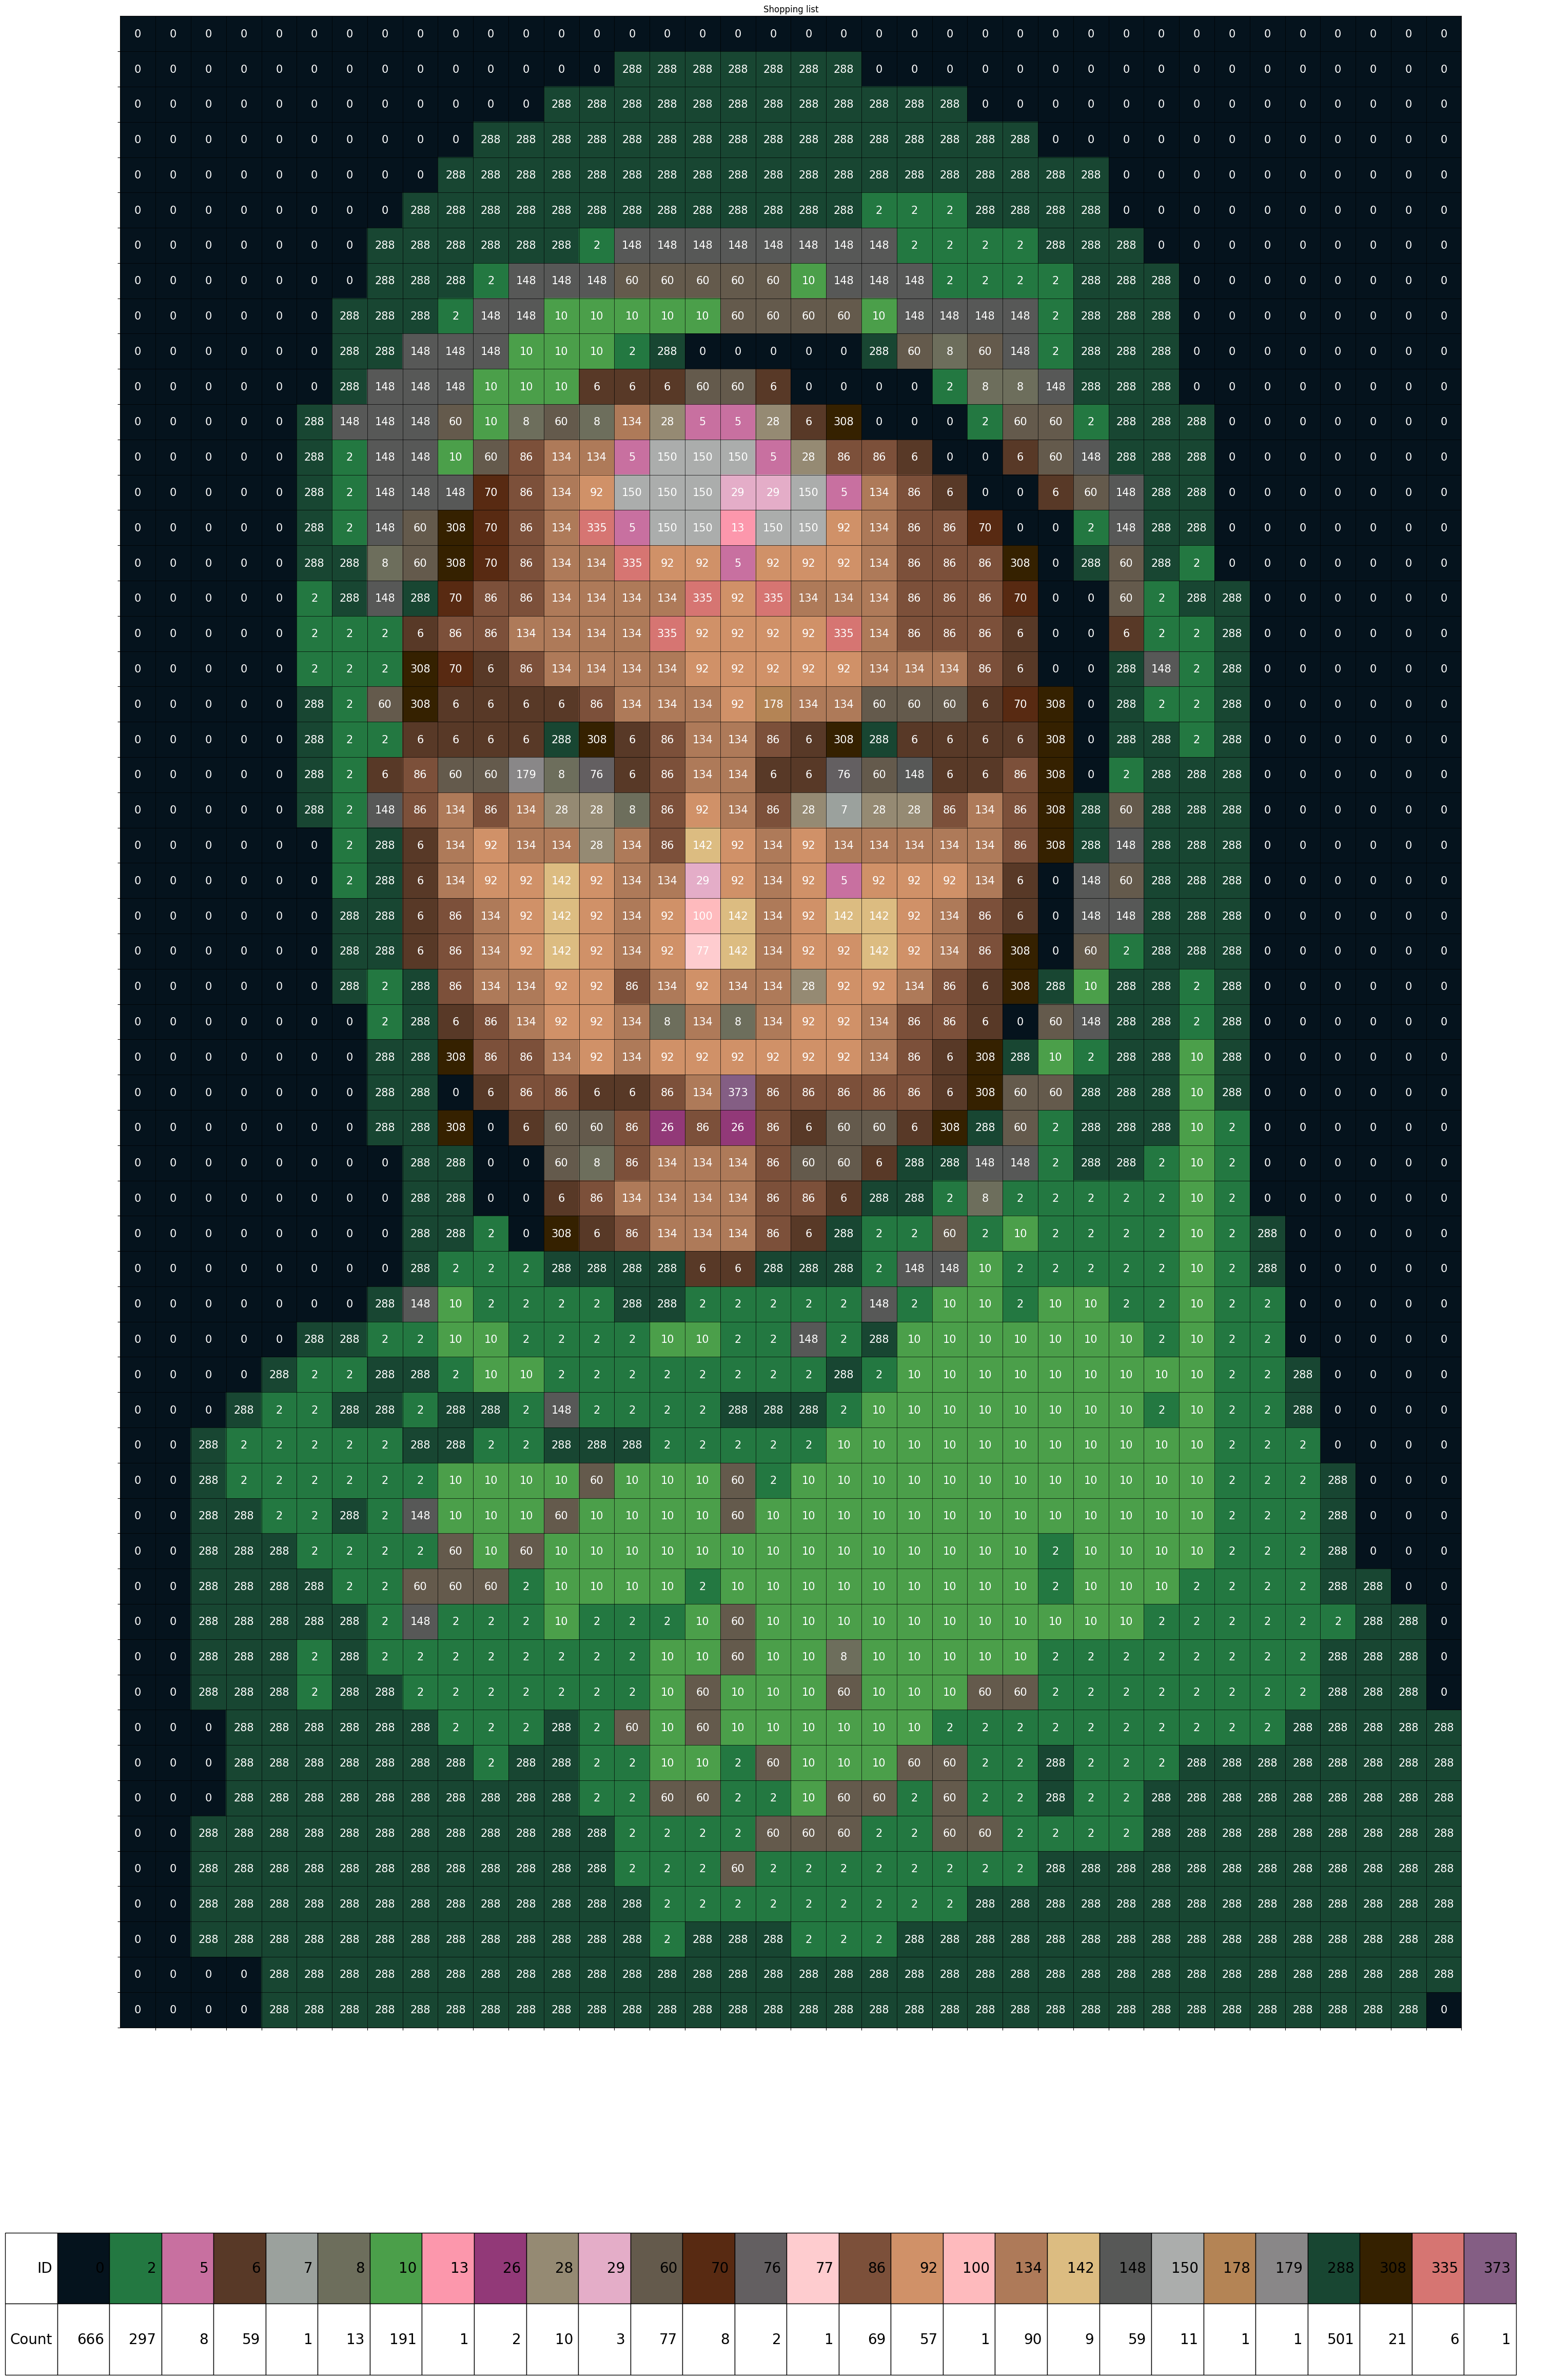

In [23]:
# Create a figure object and a subplot (2 rows and 1 column)
fig, [ax1, ax2] = plt.subplots(2, 1, gridspec_kw={'height_ratios': [lego_painting_size[1], 1]})

# Use the subplot to show the grid of LEGO colours (lego pixels image)
ax1.imshow(indexed_colour_list, cmap=custom_cmap, norm=norm)
# Move the grid ticks to sit in between the pixes instead in the middle of the pixels
ax1.set_xticks([x-0.5 for x in list(range(1,indexed_colour_list.shape[1]+1))], range(1,indexed_colour_list.shape[1]+1), visible=False)  # Hide tick labels on the x axis
ax1.set_yticks([y-0.5 for y in list(range(1,indexed_colour_list.shape[0]+1))], range(1,indexed_colour_list.shape[0]+1), visible=False)  # Hide tick labels on the y axis
ax1.grid(which="major", color='black', linestyle='-', linewidth=0.5)  #Add grid lines on all major ticks
ax1.set_title('LEGO colours (lego pixels image)')  #Set the title of the subplot

for i in range(indexed_colour_list.shape[0]):
    for j in range(indexed_colour_list.shape[1]):
        text = ax1.text(j, i, indexed_colour_list[i, j], ha="center", va="center", fontsize=15, color="white")

# Use the subplot to show the grid of LEGO colours (lego pixels image)
table = ax2.table(cellText=shoping_list, cellColours=table_colours, loc='upper right')
table.scale(1, 0.7)
table.auto_set_font_size(False)
table.set_fontsize(20)
ax2.axis('off')

# Set the figure size and save it for reference
fig.set_size_inches(lego_painting_size[0], lego_painting_size[1])
fig.savefig('lego pixels.pdf', bbox_inches='tight')